<a href="https://colab.research.google.com/github/NataliaBlueCloud/Inband_telemetry_design/blob/main/Cochrams_ofc_example_Milano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("simmer")
install.packages("SciViews")
install.packages("igraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(simmer)
library(SciViews)
library(igraph)
library(readxl)
library(ggplot2)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [ ]:
library("googledrive")
if (file.exists("/usr/local/lib/python3.10/dist-packages/google/colab/_ipython.py")){
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

In [4]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=83d99188b2444ea03f0ae389a40c8845&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYazN5M3d2TnNzOXdWZ094UTBlUEZNWXN1bVlKN1RHeU85RTRQYXhaRTRjVTc1RjZ0bjMyR2F2SE5VNTVPOVcxQSIsInN0YXRlIjoiODNkOTkxODhiMjQ0NGVhMDNmMGFlMzg5YTQwYzg4NDUifQ==


In [5]:

drive_download("r_traffic_simulation/func/igraph_function_base.R")
drive_download("r_traffic_simulation/func/igraph_functions.R")
drive_download("r_traffic_simulation/func/general_function_base.R")


File downloaded:

• igraph_function_base.R <id: 1jwogeGEqQc27cQAu8fiA1mF-KI9C41pm>

Saved locally as:

• igraph_function_base.R

File downloaded:

• igraph_functions.R <id: 1Vyg5nvBWPkMzuajVkyFELct6G1qmjMdP>

Saved locally as:

• igraph_functions.R

File downloaded:

• general_function_base.R <id: 18dycCYyQDWXi1dDVj22EoJWkeYQy-9qg>

Saved locally as:

• general_function_base.R



In [6]:
drive_download("r_traffic_simulation/input_files/Metro_topology_full_Milano.xlsx")

File downloaded:

• Metro_topology_full_Milano.xlsx <id: 1qf9aV3AICULgJEx2D98nInZwKnW8D7dn>

Saved locally as:

• Metro_topology_full_Milano.xlsx



In [31]:
source("igraph_function_base.R")
source("igraph_functions.R")
source("general_function_base.R")

In [8]:
file_name <- "Metro_topology_full_Milano.xlsx"

In [100]:
nodes_info <- read_excel(file_name, sheet = 1)
links_info <- read_excel(file_name, sheet = 2)


M/M/1 model

##Input data

In [101]:
N = 1250 #packet size (B)
CapacityGbps = 10 #Gbps

In [102]:
create_graph_object <- function(links_info, nodes_info, CapacityGbps,  N = 1250) {
  g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)
  E(g)$capacityGbps <- CapacityGbps
  E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)
  E(g)$Distance <- E(g)$distanceKm
  E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])

  return(g)
}


g <- create_graph_object(links_info, nodes_info, CapacityGbps,  N)



In [103]:
################################plot graph
NCOs <- V(g)[c(10,11,12,13,14,15,16,17,18,19)]
V(g)$color <- "gray"
V(g)$color[NCOs] <- "green" # National COs
E(g)$color <- "gray"

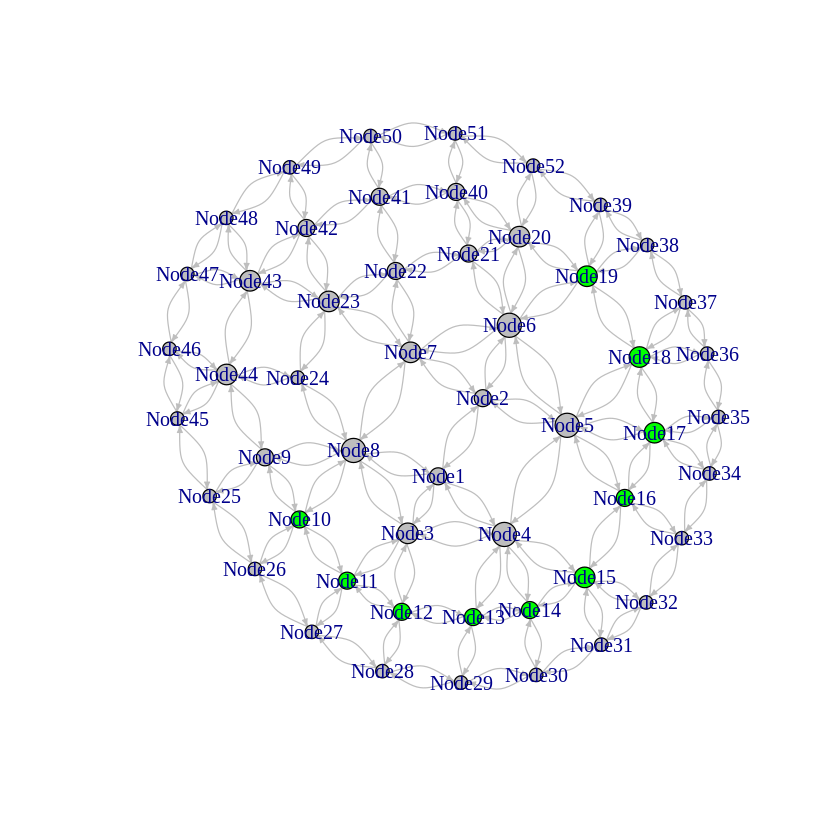

In [104]:
deg <- degree(g, mode="all")
V(g)$size <- 1 + deg*1.3/2
l <- layout.auto(g)
plot(g, edge.arrow.size=.3, vertex.label = V(g)$name, edge.curved=.5, layout=l)


## Queuing and propagation delays

In [105]:
E(g)$Load <- runif(length(E(g)), 0.1, 0.8)


In [106]:

traffic_delays_calc <- function(g) {
  E(g)$Traffic <- E(g)$Capacity*E(g)$Load

  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic)
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance
  return(g)
}

g <- traffic_delays_calc(g)

#Simulation

Simmulation of 50k packets population

In [107]:
pop_number = 50000

In [108]:
rexp_for_pop <- function(rate){
  return(rexp(n=pop_number,rate))
}

In [109]:
LCOs <- c(1:9, 20:length(V(g)))

matrx_path19_delays_us <- c()
matrx_path18_delays_us <- c()
matrx_path17_delays_us <- c()
matrx_path16_delays_us <- c()
matrx_path15_delays_us <- c()
matrx_path14_delays_us <- c()
matrx_path13_delays_us <- c()
matrx_path12_delays_us <- c()
matrx_path11_delays_us <- c()
matrx_path10_delays_us <- c()

i = 0
for (node_LCO in LCOs)
{

  path_10 <- shortest_paths(g, node_LCO, 10, weights = NULL, output = "both", algorithm = c("automatic"))
  path_10 <- E(g)[path_10[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_10]
  traffic_path_10 <-  lapply(x, rexp_for_pop)
  path10_delays = Reduce("+", traffic_path_10)  + sum(E(g)$Prop_Delay[path_10]) # in s

  path_11 <- shortest_paths(g, node_LCO, 11, weights = NULL, output = "both", algorithm = c("automatic"))
  path_11 <- E(g)[path_11[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_11]
  traffic_path_11 <-  lapply(x, rexp_for_pop)
  path11_delays = Reduce("+", traffic_path_11)  + sum(E(g)$Prop_Delay[path_11]) # in s


  path_12 <- shortest_paths(g, node_LCO, 12, weights = NULL, output = "both", algorithm = c("automatic"))
  path_12 <- E(g)[path_12[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_12]
  traffic_path_12 <-  lapply(x, rexp_for_pop)
  path12_delays = Reduce("+", traffic_path_12)  + sum(E(g)$Prop_Delay[path_12]) # in s

  path_13 <- shortest_paths(g, node_LCO, 13, weights = NULL, output = "both", algorithm = c("automatic"))
  path_13 <- E(g)[path_13[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_13]
  traffic_path_13 <-  lapply(x, rexp_for_pop)
  path13_delays = Reduce("+", traffic_path_13)  + sum(E(g)$Prop_Delay[path_13]) # in s

  path_14 <- shortest_paths(g, node_LCO, 14, weights = NULL, output = "both", algorithm = c("automatic"))
  path_14 <- E(g)[path_14[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_14]
  traffic_path_14 <-  lapply(x, rexp_for_pop)
  path14_delays = Reduce("+", traffic_path_14)  + sum(E(g)$Prop_Delay[path_14]) # in s

  path_15 <- shortest_paths(g, node_LCO, 15, weights = NULL, output = "both", algorithm = c("automatic"))
  path_15 <- E(g)[path_15[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_15]
  traffic_path_15 <-  lapply(x, rexp_for_pop)
  path15_delays = Reduce("+", traffic_path_15)  + sum(E(g)$Prop_Delay[path_15]) # in s

  path_16 <- shortest_paths(g, node_LCO, 16, weights = NULL, output = "both", algorithm = c("automatic"))
  path_16 <- E(g)[path_16[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_16]
  traffic_path_16 <-  lapply(x, rexp_for_pop)
  path16_delays = Reduce("+", traffic_path_16)  + sum(E(g)$Prop_Delay[path_16]) # in s

  path_17 <- shortest_paths(g, node_LCO, 17, weights = NULL, output = "both", algorithm = c("automatic"))
  path_17 <- E(g)[path_17[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_17]
  traffic_path_17 <-  lapply(x, rexp_for_pop)
  path17_delays = Reduce("+", traffic_path_17)  + sum(E(g)$Prop_Delay[path_17]) # in s


  path_18 <- shortest_paths(g, node_LCO, 18, weights = NULL, output = "both", algorithm = c("automatic"))
  path_18 <- E(g)[path_18[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_18]
  traffic_path_18 <-  lapply(x, rexp_for_pop)
  path18_delays = Reduce("+", traffic_path_18)  + sum(E(g)$Prop_Delay[path_18]) # in s

  path_19 <- shortest_paths(g, node_LCO, 19, weights = NULL, output = "both", algorithm = c("automatic"))
  path_19 <- E(g)[path_19[["epath"]][[1]]]
  x <- 1/E(g)$Queue_Delay[path_19]
  traffic_path_19 <-  lapply(x, rexp_for_pop)
  path19_delays = Reduce("+", traffic_path_19)  + sum(E(g)$Prop_Delay[path_19]) # in s

  path19_delays_us <- path19_delays*1e6# in us
  path18_delays_us <- path18_delays*1e6# in us
  path17_delays_us <- path17_delays*1e6# in us
  path16_delays_us <- path16_delays*1e6# in us
  path15_delays_us <- path15_delays*1e6# in us
  path14_delays_us <- path14_delays*1e6# in us
  path13_delays_us <- path13_delays*1e6# in us
  path12_delays_us <- path12_delays*1e6# in us
  path11_delays_us <- path11_delays*1e6# in us
  path10_delays_us <- path10_delays*1e6# in us
  matrx_path19_delays_us <- rbind(matrx_path19_delays_us, path19_delays_us)
  matrx_path18_delays_us <- rbind(matrx_path18_delays_us, path18_delays_us)
  matrx_path17_delays_us <- rbind(matrx_path17_delays_us, path17_delays_us)
  matrx_path16_delays_us <- rbind(matrx_path16_delays_us, path16_delays_us)
  matrx_path15_delays_us <- rbind(matrx_path15_delays_us, path15_delays_us)
  matrx_path14_delays_us <- rbind(matrx_path14_delays_us, path14_delays_us)
  matrx_path13_delays_us <- rbind(matrx_path13_delays_us, path13_delays_us)
  matrx_path12_delays_us <- rbind(matrx_path12_delays_us, path12_delays_us)
  matrx_path11_delays_us <- rbind(matrx_path11_delays_us, path11_delays_us)
  matrx_path10_delays_us <- rbind(matrx_path10_delays_us, path10_delays_us)
  i = i + 1
  rownames(matrx_path19_delays_us)[i] <- c(i)
  rownames(matrx_path18_delays_us)[i] <- c(i)
  rownames(matrx_path17_delays_us)[i] <- c(i)
  rownames(matrx_path16_delays_us)[i] <- c(i)
  rownames(matrx_path15_delays_us)[i] <- c(i)
  rownames(matrx_path14_delays_us)[i] <- c(i)
  rownames(matrx_path13_delays_us)[i] <- c(i)
  rownames(matrx_path12_delays_us)[i] <- c(i)
  rownames(matrx_path11_delays_us)[i] <- c(i)
  rownames(matrx_path10_delays_us)[i] <- c(i)

}



In [110]:
### Z - NCOs, rows - LCOs, cols - 1 sim delay of 50k
matrx_paths <- array(rep(0, length(NCOs)*length(LCOs)*pop_number), dim = c(length(NCOs), length(LCOs), pop_number))
matrx_paths[1,,] <- matrx_path10_delays_us
matrx_paths[2,,] <- matrx_path11_delays_us
matrx_paths[3,,] <- matrx_path12_delays_us
matrx_paths[4,,] <- matrx_path13_delays_us
matrx_paths[5,,] <- matrx_path14_delays_us
matrx_paths[6,,] <- matrx_path15_delays_us
matrx_paths[7,,] <- matrx_path16_delays_us
matrx_paths[8,,] <- matrx_path17_delays_us
matrx_paths[9,,] <- matrx_path18_delays_us
matrx_paths[10,,] <- matrx_path19_delays_us


#Results

In [111]:
n_exp <- 100

Threshold of each LCO

In [112]:
threshold_us <- 10
LCOs_thesholds <- rep(threshold_us, length(LCOs))
LCOs_thesholds[c(12,13,31,32,33,35,36,37,38,40, 41)] <- 20
LCOs_thesholds[39] <- 30

In [113]:
table_to_df <- function(path_delays, threshold_us){
  df_p <- as.data.frame(table(path_delays < threshold_us, useNA = "always"))
  df_p$Var1 <- as.logical(df_p$Var1)
  df_p$Var1[2] = ifelse(df_p$Var1[1] == 1, 0, 1)
  return(df_p)
}

In [114]:
calc_results <- function(matrx_paths, g, LCOs, NCOs, LCOs_thesholds,n_samples, n_exp)
{

  matrx_paths_sampled <- array(rep(0, length(NCOs)*length(LCOs)*n_samples), dim = c(length(NCOs), length(LCOs), n_samples))
  percent_below_thr <- array(rep(0, length(NCOs)*length(LCOs)*n_exp), dim = c(length(NCOs), length(LCOs), n_exp))
  results <- array(rep(0, length(LCOs)*n_exp), dim = c(length(LCOs), n_exp))
  percent_below_thr_p1 <- c()
  percent_below_thr_p2 <- c()
  percent_below_thr_p3 <- c()
  for (exp in 1:n_exp)
  {
    for(l in 1:length(LCOs))

    {
      table_res <- c()
      for (n in 1:length(NCOs))
      {
        matrx_paths_sampled[n,l,] = sample( matrx_paths[n,l, ], size=n_samples, replace=F)
        percent_below_thr[n,l,exp] <- length(matrx_paths_sampled[n,l,][matrx_paths_sampled[n,l,] < LCOs_thesholds[l]])/length(matrx_paths_sampled[n,l,])*100
        df_p <- table_to_df(matrx_paths_sampled[n,l,], LCOs_thesholds[l])
        df_p <- df_p[order(df_p$Var1),]
        table_res[n] <- df_p$Freq[2]

      }
      if (length(which( table_res != 0, arr.ind = FALSE)) == 0)
      {
        print(paste("Change the threshold of", LCOs[l], "node, row =", l))
      }

      if (length(which(table_res/n_samples < 1, arr.ind = FALSE)) == 0)
      {
        print(paste("Change (decrease, all NCO percent_below_thr = 100 %) the threshold of", LCOs[l], "node, row =", l))
      }

      results[l, exp] <- NCOs[which.max(table_res)]

    }

  }

  return(list(results,percent_below_thr))
}

Samples size - 10 packets

In [115]:
c(results_10p, percent_below_thr_10p) := calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 10, n_exp)


Samples size - 41 packets

In [116]:
c(results_41p, percent_below_thr_41p) := calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 41, n_exp)


Samples size - 164 packets

In [117]:
c(results_164p, percent_below_thr_164p) := calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples =164, n_exp)


Samples size - 452 packets

In [118]:
c(results_452p, percent_below_thr_452p) := calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 452, n_exp)

Calculations for the entire population

In [119]:
c(results_50kp, percent_below_thr_50kp) := calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 50000, n_exp = 1)

In [120]:
perc_correct_decision_10p <- c()
perc_correct_decision_41p <- c()
perc_correct_decision_164p <- c()
perc_correct_decision_452p <- c()

for(l in 1:length(LCOs))
{
  results_10p_LCO <- results_10p[l,]
  perc_correct_decision_10p[l] <- length(results_10p_LCO[results_10p_LCO == results_50kp[l]])/length(results_10p_LCO)*100
  results_41p_LCO <- results_41p[l,]
  perc_correct_decision_41p[l] <- length(results_41p_LCO[results_41p_LCO == results_50kp[l]])/length(results_41p_LCO)*100
  results_164p_LCO <- results_164p[l,]
  perc_correct_decision_164p[l] <- length(results_164p_LCO[results_164p_LCO == results_50kp[l]])/length(results_164p_LCO)*100
  results_452p_LCO <- results_452p[l,]
  perc_correct_decision_452p[l] <- length(results_452p_LCO[results_452p_LCO == results_50kp[l]])/length(results_452p_LCO)*100
}
print(paste("P% correct decision 10 packet", mean(perc_correct_decision_10p)))
print(paste("P% of error 10 packet", 100 - mean(perc_correct_decision_10p)))
print(paste("P% correct decision 41 packet", mean(perc_correct_decision_41p)))
print(paste("P% of error 41 packet", 100 - mean(perc_correct_decision_41p)))
print(paste("P% correct decision 164 packet", mean(perc_correct_decision_164p)))
print(paste("P% of error 164 packet", 100 - mean(perc_correct_decision_164p)))
print(paste("P% correct decision 452 packet", mean(perc_correct_decision_452p)))
print(paste("P% of error 452 packet", 100 - mean(perc_correct_decision_452p)))

[1] "P% correct decision 10 packet 88.1904761904762"
[1] "P% of error 10 packet 11.8095238095238"
[1] "P% correct decision 41 packet 96.1666666666667"
[1] "P% of error 41 packet 3.83333333333333"
[1] "P% correct decision 164 packet 98.8095238095238"
[1] "P% of error 164 packet 1.19047619047619"
[1] "P% correct decision 452 packet 99.7380952380952"
[1] "P% of error 452 packet 0.261904761904759"


#Boxplots

Sample size - 10 packets

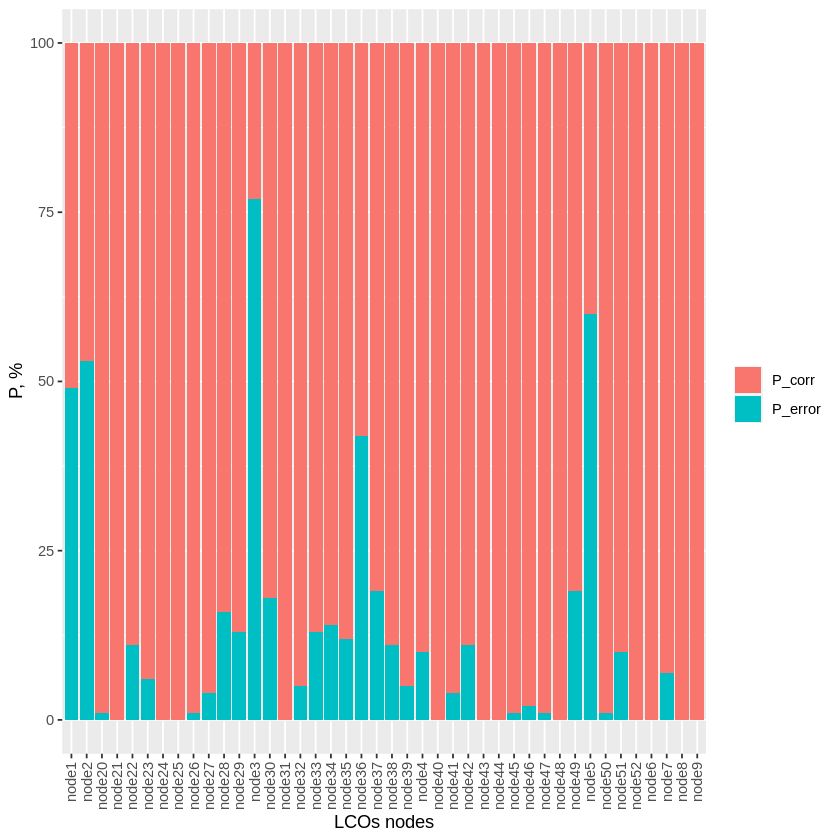

In [121]:

data=data.frame(perc_decision = c(perc_correct_decision_10p, 100 - perc_correct_decision_10p),
                LCOs_nodes <- c(paste0("node", LCOs), paste0("node", LCOs)),
                percent = c(rep("P_corr",length(perc_correct_decision_10p)),rep("P_error",length(perc_correct_decision_10p)) ))
ggplot(data, aes(x=LCOs_nodes, y=perc_decision, fill=percent)) +
  geom_bar(stat="identity") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  xlab("LCOs nodes") +
  ylab("P, %") +
  scale_fill_discrete(name = "")


Sample size - 452 packets

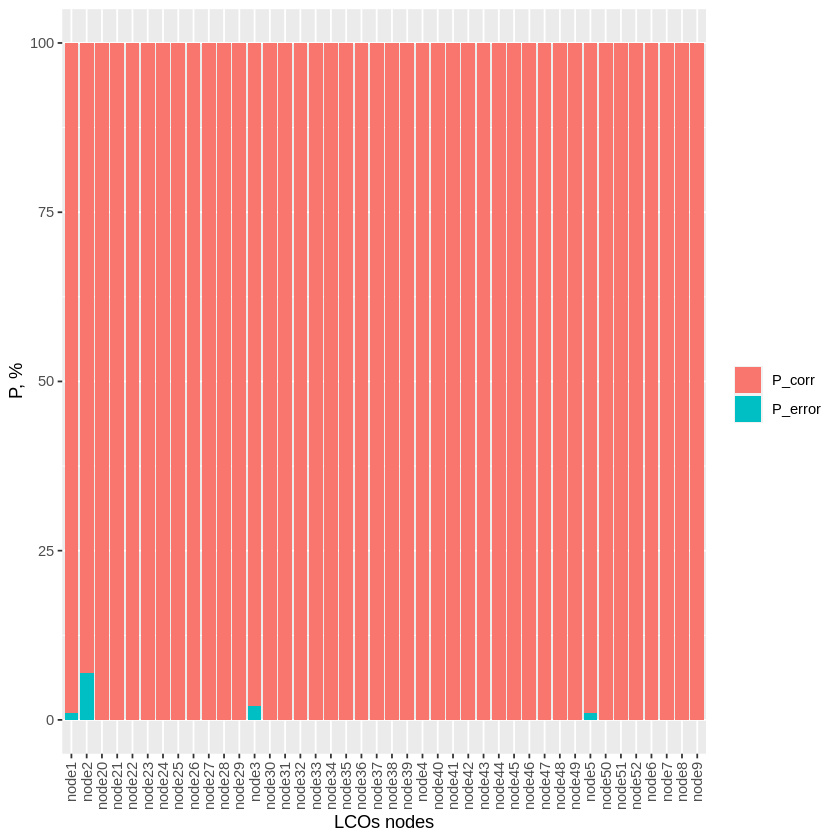

In [122]:

data=data.frame(perc_decision = c(perc_correct_decision_452p, 100 - perc_correct_decision_452p),
                LCOs_nodes <- c(paste0("node", LCOs), paste0("node", LCOs)),
                percent = c(rep("P_corr",length(perc_correct_decision_452p)),rep("P_error",length(perc_correct_decision_452p)) ))
ggplot(data, aes(x=LCOs_nodes, y=perc_decision, fill=percent)) +
  geom_bar(stat="identity") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  xlab("LCOs nodes") +
  ylab("P, %") +
  scale_fill_discrete(name = "")